<a href="https://colab.research.google.com/github/ymuto0302/base1_2021/blob/main/GIS3_5_real_market_area_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 現実の店舗を対象とした商圏人口の推定
以下では，山口県の地理情報および店舗の位置が緯度・経度で与えられることを前提として，これらを平面直角座標系 (Plane Rectangular Coordinate System）へ投影し，さらにバッファリングにより商圏を設定した上で，商圏人口を推定する。

---
## (準備) geopandas および rtree のインストール
本ノートブック上で sjoin() を利用するため，rtree が必要となる。

また，geopandas について，Google Colab が標準で提供する geopandas はバージョンの整合が取れていないようだから，github から最新のソースを持ってくる。

（参考にしたサイト）https://colab.research.google.com/drive/1Kt3vPVIQJUq4QeJ-rE08URpIJEr1g2H3#scrollTo=DT-2i68kvoiN

In [1]:
!pip install git+git://github.com/geopandas/geopandas.git

  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-p1uzea95
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-p1uzea95
     |████████████████████████████████| 15.4 MB 37 kB/s 
     |████████████████████████████████| 6.3 MB 35.1 MB/s 
  Created wheel for geopandas: filename=geopandas-0.10.2-py2.py3-none-any.whl size=1031400 sha256=0aa0f322f1e44a8f1d300c07326700c23418437f7d874a37cfe22dca43a08ae3
  Stored in directory: /tmp/pip-ephem-wheel-cache-tr6_ojcf/wheels/cf/3e/0b/6475054094c2b1ea054158ac1fdcf749fb92f5b512377e4cf8
Successfully built geopandas


In [2]:
!apt install python3-rtree 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 37 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-pkg-resources all 39.0.1-2 [98.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 k

(準備) Google Drive のマウント

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
## (復習) 山口県の人口データの取得
(注) これは前々回の授業内容である。

「地図で見る統計(統計GIS)」 https://www.e-stat.go.jp/gis から国勢調査の結果を取得し，山口県のデータが shapefile "h27ka35.shp" に格納されていることを前提とする。

In [5]:
import geopandas as gpd

# 地理情報データの読み込み
yamaguchi = gpd.read_file(r'/content/drive/My Drive/BASE/GeoData/e-stat/Yamaguchi/h27ka35.shp')

# 水面調査区の除去
yamaguchi = yamaguchi[yamaguchi['HCODE'] != 8154]

### CRSの確認およびデータの中身を確認
- CRS を見ると，座標系として緯度・経度が利用されている。(Axis Info の値を参照）
- データ "yamaguchi" には町名・丁名，面積，人口など，多様なデータが格納されている。

In [6]:
# CRS の確認
yamaguchi.crs

<Geographic 2D CRS: EPSG:4612>
Name: JGD2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Japan - onshore and offshore.
- bounds: (122.38, 17.09, 157.65, 46.05)
Datum: Japanese Geodetic Datum 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
# データ "yamaguchi" の中身を確認
yamaguchi.head()

,KEY_CODE,PREF,CITY,S_AREA,PREF_NAME,CITY_NAME,S_NAME,KIGO_E,HCODE,AREA,PERIMETER,H27KAxx_,H27KAxx_ID,KEN,KEN_NAME,SITYO_NAME,GST_NAME,CSS_NAME,KIHON1,DUMMY1,KIHON2,KEYCODE1,KEYCODE2,AREA_MAX_F,KIGO_D,N_KEN,N_CITY,KIGO_I,MOJI,KBSUM,JINKO,SETAI,X_CODE,Y_CODE,KCODE1,geometry
0,352010010,35,201,001000,山口県,下関市,みもすそ川町,None,8101,442768.393,3227.962,1312,1311,35,山口県,None,下関市,None,0010,-,00,201001000,2010010,M,None,None,None,None,みもすそ川町,22,614,319,130.95720,33.96867,0010-00,"POLYGON ((130.95730 33.96578, 130.95720 33.965..."
1,352010020,35,201,002000,山口県,下関市,壇之浦町,None,8101,124091.706,2073.968,1857,1856,35,山口県,None,下関市,None,0020,-,00,201002000,2010020,M,None,None,None,None,壇之浦町,9,269,151,130.95358,33.96282,0020-00,"POLYGON ((130.95132 33.96013, 130.95126 33.960..."
2,35201003001,35,201,003001,山口県,下関市,本町１丁目,None,8101,82267.204,1776.367,3922,3921,35,山口県,None,下関市,None,0030,-,01,201003001,201003001,M,None,None,None,None,本町１丁目,12,300,189,130.95174,33.96380,0030-01,"POLYGON ((130.95137 33.96206, 130.95123 33.961..."
3,35201003002,35,201,003002,山口県,下関市,本町２丁目,None,8101,61971.124,1095.964,372,371,35,山口県,None,下関市,None,0030,-,02,201003002,201003002,M,None,None,None,None,本町２丁目,11,347,172,130.94960,33.96461,0030-02,"POLYGON ((130.95036 33.96348, 130.95035 33.963..."
4,35201003003,35,201,003003,山口県,下関市,本町３丁目,None,8101,98355.229,1720.175,3447,3446,35,山口県,None,下関市,None,0030,-,03,201003003,201003003,M,None,None,None,None,本町３丁目,10,217,108,130.94776,33.96626,0030-03,"POLYGON ((130.94823 33.96506, 130.94830 33.964..."


### 人口を眺めてみる

In [12]:
# 市名(CITY_NAME)，町丁・字等名称(S_NAME)，人口(JINKO)，geometry のみを抽出
yamaguchi = yamaguchi[['CITY_NAME', 'S_NAME', 'JINKO', 'geometry']]

# 変数 yanaguchi の中身をチェック
yamaguchi.head()

,CITY_NAME,S_NAME,JINKO,geometry
0,下関市,みもすそ川町,614,"POLYGON ((130.95730 33.96578, 130.95720 33.965..."
1,下関市,壇之浦町,269,"POLYGON ((130.95132 33.96013, 130.95126 33.960..."
2,下関市,本町１丁目,300,"POLYGON ((130.95137 33.96206, 130.95123 33.961..."
3,下関市,本町２丁目,347,"POLYGON ((130.95036 33.96348, 130.95035 33.963..."
4,下関市,本町３丁目,217,"POLYGON ((130.94823 33.96506, 130.94830 33.964..."


---
### 平面直角座標系への変換
商圏を設定する場合，平面直角座標系，つまりメートル単位の座標系を用いる。
変換方法は，以下のとおり to_crs() メソッドを用いる。

In [13]:
# 投影座標系の変換（平面直角座標系への変換）
projected_yamaguchi = yamaguchi.to_crs('EPSG:2443', inplace=False)

projected_yamaguchi.head()

,CITY_NAME,S_NAME,JINKO,geometry
0,下関市,みもすそ川町,614,"POLYGON ((134678.200 108064.501, 134669.018 10..."
1,下関市,壇之浦町,269,"POLYGON ((134134.473 107428.889, 134129.083 10..."
2,下関市,本町１丁目,300,"POLYGON ((134136.263 107643.442, 134123.824 10..."
3,下関市,本町２丁目,347,"POLYGON ((134040.398 107799.199, 134039.616 10..."
4,下関市,本町３丁目,217,"POLYGON ((133841.319 107972.579, 133848.282 10..."


---
# ここから本番！！

## ステップ１：仮想的な店舗配置による商圏人口の算出
最初に仮想的な店舗を１店のみ考え，思い通りの位置には配置できるか／商圏を設定できるか，を確認する。

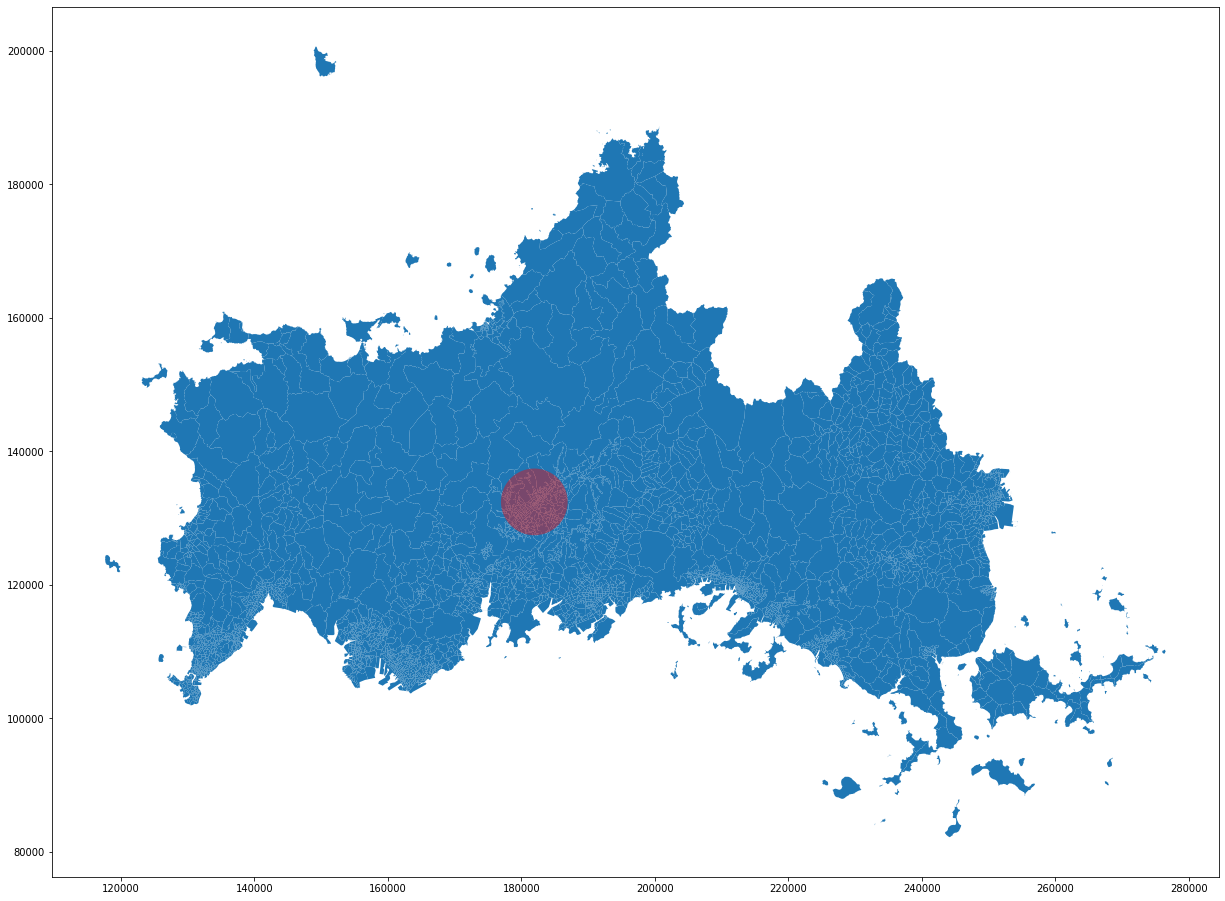

In [18]:
# 店舗の定義
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# 地理情報データの読み込み
yamaguchi = gpd.read_file(r'/content/drive/My Drive/BASE/GeoData/e-stat/Yamaguchi/h27ka35.shp')
yamaguchi = yamaguchi[yamaguchi['HCODE'] != 8154] # 水面調査区の除去

# 市名(CITY_NAME)，町丁・字等名称(S_NAME)，人口(JINKO)，geometry のみを抽出
yamaguchi = yamaguchi[['CITY_NAME', 'S_NAME', 'JINKO', 'geometry']]

# 投影座標系の変換（平面直角座標系への変換）
projected_yamaguchi = yamaguchi.to_crs('EPSG:2443', inplace=False)

# 山口市中心部(東経 131.473843度, 北緯 34.178295度)に仮想店舗を設置する
shop = gpd.GeoDataFrame([['shopA', Point(131.473843, 34.178295)]],
                        columns=['name', 'geometry'],
                        crs='EPSG:4612')

#  仮想店舗を平面直角座標系へ変換した上で，半径 5[km] の商圏を設定
market_area = shop.to_crs('EPSG:2443', inplace=False)
buffer_size = 5000 # 5000[m] = 5[km]
market_area['geometry'] = market_area.buffer(buffer_size) # 半径 5km (5000m) のポリゴンを生成

# 可視化
fig, ax = plt.subplots(1, figsize=(32, 16))
projected_yamaguchi.plot(ax=ax)
market_area.plot(ax=ax, color="red", alpha=0.4)

### 商圏内の人口を求める

In [19]:
# 山口の地理情報と商圏を空間的に結合(spatial join)する
joined = gpd.sjoin(projected_yamaguchi, market_area, predicate='within')

projected_yamaguchi (山口県の地理情報データ)と market_area (仮想店舗の商圏）を空間結合すると，山口市 木町／香山町／水の上町／金古曽町／石観音町などが商圏に含まれることが分かる。

In [21]:
# 空間結合されたデータの中身を確認
joined.head()

,CITY_NAME,S_NAME,JINKO,geometry,index_right,name
1233,山口市,木町,294,"POLYGON ((182162.162 133806.984, 182160.666 13...",0,shopA
1234,山口市,香山町,228,"POLYGON ((182063.003 133555.508, 182057.036 13...",0,shopA
1235,山口市,水の上町,170,"POLYGON ((182035.648 133225.542, 181999.384 13...",0,shopA
1236,山口市,金古曽町,349,"POLYGON ((183062.025 133133.195, 182961.611 13...",0,shopA
1237,山口市,石観音町,157,"POLYGON ((182828.830 132955.392, 182770.075 13...",0,shopA


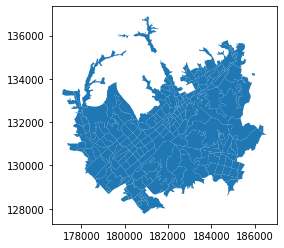

In [22]:
# 空間結合されたデータの可視化
joined.plot()

In [23]:
# (参考) 商圏内に町丁・字等名称(S_NAME)が何件含まれるか，見ておくと 251件のようだ
len(joined)

251

最後にグルーピング機能を用いて，商圏内の総人口を求める。

In [24]:
# 商圏人口の算出
for name, group in joined.groupby('name'):
    total_pop = group['JINKO'].sum()
    print("{} の商圏人口：{}人".format(name, total_pop))

shopA の商圏人口：98740人


## ステップ２：現実の店舗配置による商圏人口の算出
山口県内で展開しているスーパー・チェーン「まるき」（株式会社 丸喜）を取り上げる。

In [25]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# 地理情報データの読み込み
yamaguchi = gpd.read_file(r'/content/drive/My Drive/BASE/GeoData/e-stat/Yamaguchi/h27ka35.shp')
yamaguchi = yamaguchi[yamaguchi['HCODE'] != 8154] # 水面調査区の除去

# 投影座標系の変換（平面直角座標系への変換）
projected_yamaguchi = yamaguchi.to_crs('EPSG:2443', inplace=False)

# まるき店舗データの読み込み
maruki = pd.read_excel('/content/drive/My Drive/BASE/GeoData/maruki.xlsx')

# 店舗の定義
# [[店舗名A, Point(経度A,緯度A)], [店舗名B, Point(経度B,緯度B)], [店舗名C, Point(経度C,緯度C)]] の形のリストを作る
number_of_shop = len(maruki)
shop_list = list()
for idx in range(number_of_shop):
    data = maruki.iloc[idx]
    shop_list.append([data['店舗名'], Point(data['経度'], data['緯度'])])

# リストを GeoDataFrame へ変換
shops = gpd.GeoDataFrame(shop_list,
                         columns=['name', 'geometry'], crs='EPSG:4612')

# 店舗位置を投影座標系へ変換した後，各店舗に半径 3km の商圏を設定
market_area = shops.to_crs('EPSG:2443', inplace=False) # 投影座標系の変換

buffer_size = 3000 # 3000[m] = 3[km]
market_area['geometry'] = market_area.buffer(buffer_size) # 半径 buffer_size のポリゴンを生成

# 山口の地理情報と商圏を空間的に結合(spatial join)する
joined = gpd.sjoin(projected_yamaguchi, market_area, predicate='within')

In [26]:
# 空間結合の結果である変数 joined を除き見る
joined.head()

,KEY_CODE,PREF,CITY,S_AREA,PREF_NAME,CITY_NAME,S_NAME,KIGO_E,HCODE,AREA,PERIMETER,H27KAxx_,H27KAxx_ID,KEN,KEN_NAME,SITYO_NAME,GST_NAME,CSS_NAME,KIHON1,DUMMY1,KIHON2,KEYCODE1,KEYCODE2,AREA_MAX_F,KIGO_D,N_KEN,N_CITY,KIGO_I,MOJI,KBSUM,JINKO,SETAI,X_CODE,Y_CODE,KCODE1,geometry,index_right,name
4,35201003003,35,201,003003,山口県,下関市,本町３丁目,None,8101,98355.229,1720.175,3447,3446,35,山口県,None,下関市,None,0030,-,03,201003003,201003003,M,None,None,None,None,本町３丁目,10,217,108,130.94776,33.96626,0030-03,"POLYGON ((133841.319 107972.579, 133848.282 10...",24,まるき武久店
13,35201010001,35,201,010001,山口県,下関市,貴船町１丁目,None,8101,85250.573,1291.718,2279,2278,35,山口県,None,下関市,None,0100,-,01,201010001,201010001,M,None,None,None,None,貴船町１丁目,20,655,328,130.94406,33.96415,0100-01,"POLYGON ((133622.320 107819.282, 133586.810 10...",24,まるき武久店
14,35201010002,35,201,010002,山口県,下関市,貴船町２丁目,None,8101,129996.708,1761.084,1553,1552,35,山口県,None,下関市,None,0100,-,02,201010002,201010002,M,None,None,None,None,貴船町２丁目,22,461,211,130.94426,33.96632,0100-02,"POLYGON ((133390.596 108000.460, 133383.787 10...",24,まるき武久店
15,35201010003,35,201,010003,山口県,下関市,貴船町３丁目,None,8101,180161.457,2177.559,2739,2738,35,山口県,None,下関市,None,0100,-,03,201010003,201010003,M,None,None,None,None,貴船町３丁目,20,814,331,130.94364,33.96927,0100-03,"POLYGON ((133367.261 108195.275, 133368.091 10...",24,まるき武久店
16,35201010004,35,201,010004,山口県,下関市,貴船町４丁目,None,8101,152406.469,1940.972,965,964,35,山口県,None,下関市,None,0100,-,04,201010004,201010004,M,None,None,None,None,貴船町４丁目,15,942,424,130.93958,33.97117,0100-04,"POLYGON ((133170.730 108425.027, 133164.850 10...",24,まるき武久店


商圏に含まれる地域を可視化

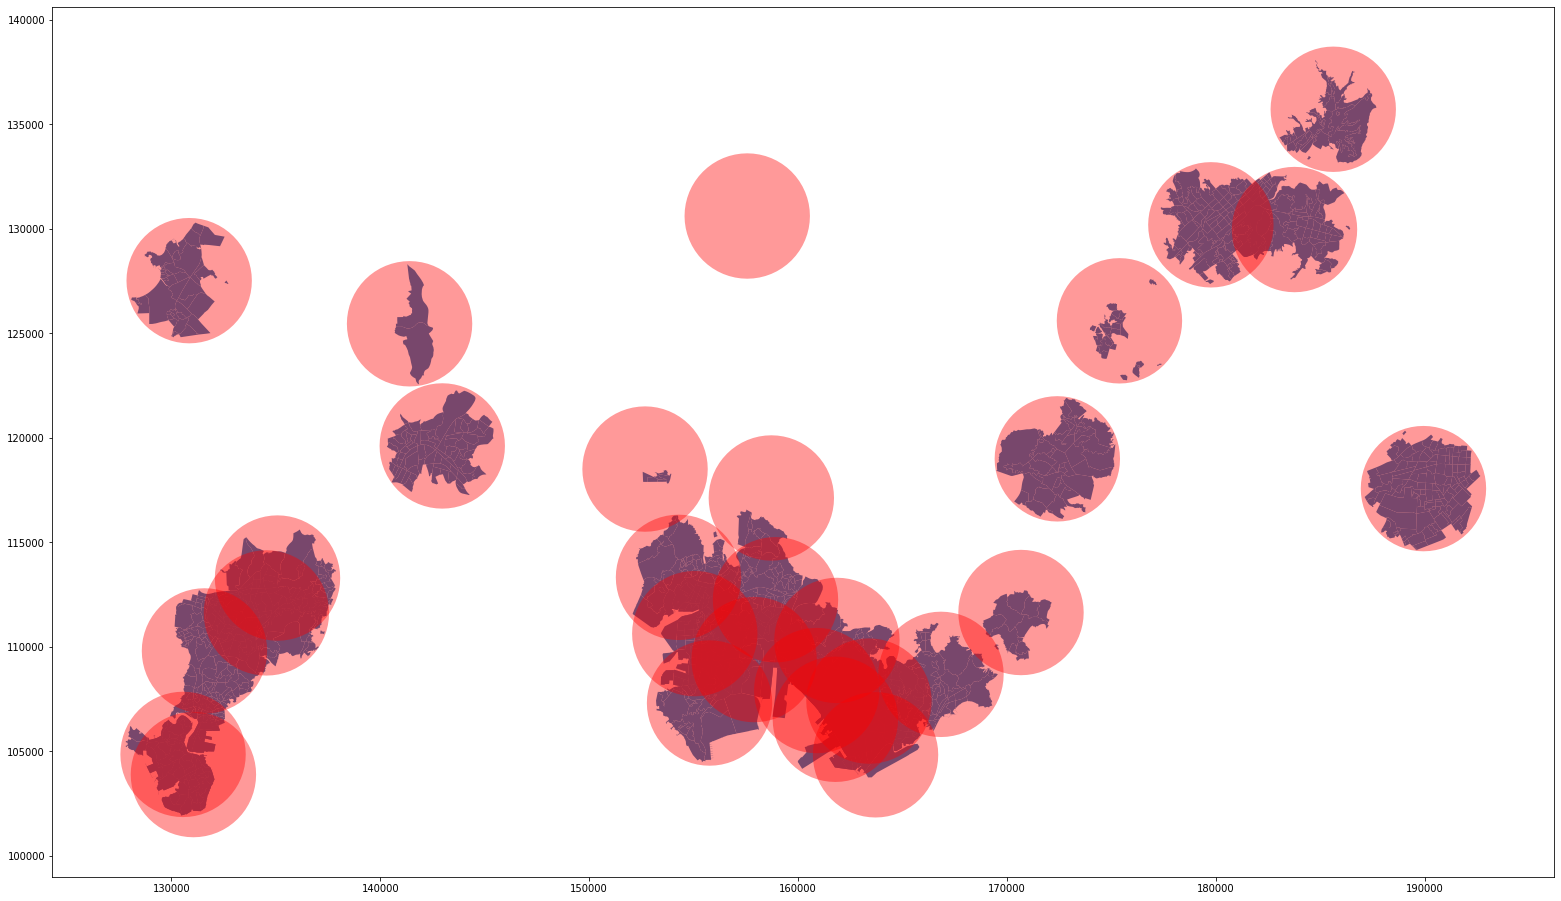

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(32, 16))
joined.plot(ax=ax)
market_area.plot(ax=ax, color='red', alpha=0.4)

最後に，各店舗の商圏人口を算出する。

In [28]:
# 商圏人口の算出
print("=== 商圏人口の一覧 ===")
for name, group in joined.groupby('name'):
    total_pop = group['JINKO'].sum()
    print("{}：{}人".format(name, total_pop))

=== 商圏人口の一覧 ===
まるき小野田大学通り店：21558人
まるき山口嘉川店：6763人
まるき常盤通り店：56470人
まるき彦島店：37045人
まるき武久店：76259人
まるき角倉店：26687人
ウェスタまるき下関一の宮店：54041人
ウェスタまるき下関小月店：11988人
ウェスタまるき下関形山店：40054人
ウェスタまるき中川店：28119人
ウェスタまるき厚狭店：665人
ウェスタまるき小松原通り店：48107人
ウェスタまるき小羽山店：36893人
ウェスタまるき小郡店：9040人
ウェスタまるき山口大内店：32182人
ウェスタまるき山口宮野店：10944人
ウェスタまるき山口湯田店：57654人
ウェスタまるき工学部通り店：70055人
ウェスタまるき東岐波店：6811人
ウェスタまるき楠店：1136人
ウェスタまるき神田店：18347人
ウェスタまるき空港通り店：35393人
ウェスタまるき菊川店：3175人
ウェスタまるき華城店：57476人
ウェスタまるき西割店：37969人
ウェスタまるき西宇部店：30285人
ウェスタまるき西岐波店：25820人
ウェスタまるき豊浦店：8089人
